# 911-Crime detection using Xception Model

###### By Project ATMA Team

#### Intro

For our model, we decided that we will be using the Xception model proposed by François Chollet himself, the creator and maintainer of the Keras library.

Original Publication: https://arxiv.org/abs/1610.02357

Important things:
    - Fine tuning of top layers (in keras.io website)
    - transfer learning/value extracting
    - helped from Abner Ayala's "Transfer Learning: Keras Xception CNN
    - ffmpeg to convert videos to frames
    

In [2]:
# Modules to display images
from IPython.display import Image
from IPython.core.display import HTML 

In [3]:
Image(url= "images/imagenet_xception_flow.png")

##### Data directory Structure

##### Import Modules

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
import pandas
import os
import sys

from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.models import load_model
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

'''
In the end, we can be more specific and
only import the modules we actually use

from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten

from tensorflow.python.keras.optimizers import Adam

from tensorflow.python.keras.models import Model

from tensorflow.python.keras.models import load_model

from tensorflow.python.keras import backend as K
'''

Using TensorFlow backend.


'\nIn the end, we can be more specific and\nonly import the modules we actually use\n\nfrom tensorflow.python.keras.layers import InputLayer, Input\nfrom tensorflow.python.keras.layers import Reshape, MaxPooling2D\nfrom tensorflow.python.keras.layers import Conv2D, Dense, Flatten\n\nfrom tensorflow.python.keras.optimizers import Adam\n\nfrom tensorflow.python.keras.models import Model\n\nfrom tensorflow.python.keras.models import load_model\n\nfrom tensorflow.python.keras import backend as K\n'

In [4]:
# check version of anything. In this case, we check tensorflow
tf.__version__

'1.11.0'

##### Hyperparameters

In [5]:
num_classes = 10
last_block_layer_of_base_model = 126
img_width, img_height = 299, 299 # used for the input image shape of the base model
batch_size = 32 # we can try 4,8,32,64,128,256,..
num_epochs = 50 # number of iterations the algorithm gets trained
learning_rate = 0.045 # for sgd optimizer
learning_rate_decay = 0.94 # every two seconds
momentum = 0.9 # momentum used for the sgd optimizer
transformation_ratio = .05 # how aggressive will the data augmentation/transformation be


##### Model quick building

In [7]:
#Graph/Architecture
base_model = Xception(input_shape=(img_width, img_height, 3), weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(2, activation='softmax')(x)

#Model creation
model = Model(base_model.input, predictions)
print(model.summary())

83689472/83683744 [==============================] - 37s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________

##### Freezing the Top Layers

In [1]:
'''
for layer in base_model.layers:
    layer.trainable = False
    
# freeze for fine tuning
'''

'\nfor layer in base_model.layers:\n    layer.trainable = False\n    \n# freeze for fine tuning\n'

##### Data generation / parameters randomization

In [ ]:
# functions that will be used to change the image parameters for randomness
# Note: the validation data generator only rescales the images for obvious reasons
train_datagen = ImageDataGenerator(rescale=1. / 255,
                   rotation_range=transformation_ratio,
                   shear_range=transformation_ratio,
                   zoom_range=transformation_ratio,
                   cval=transformation_ratio,
                   horizontal_flip=True,
                   vertical_flip=True)

validation_datagen = ImageDataGenerator(rescale=1. / 255)
'''
validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                          target_size=(img_width, img_height),
                          batch_size=batch_size,
                          class_mode='categorical')
'''

# Creates new directory if it does not exist, in the joined path of the train_data_dir path
'''
os.makedirs(os.path.join(os.path.abspath(train_data_dir), '../preview'), exist_ok=True)
'''

# the data generator takes in:
    # The directory of the data
    # gets a small batch size of files
    # resizes them to the target_size
# it spits out a batch of images with different parameters
'''
train_generator = train_datagen.flow_from_directory(train_data_dir,
                    target_size=(img_width, img_height),
                    batch_size=batch_size,
                    class_mode='categorical')
'''

##### Model Compilation

In [ ]:
model.compile(optimizer='nadam',
              loss='categorical_crossentropy', #Categorical cross entropy for multiple classes
             metrics=['accuracy'])

#####  We will use CIFAR-10 data to test our model - NO because the images are 32x32

In [1]:
'''
import cifar10

from cifar10 import num_classes

# Change the path to which the data folder will be downloaded to.
cifar10.data_path = "data/CIFAR-10/"

# downloads and extracts the data IFF it has not been done so yet.
cifar10.maybe_download_and_extract()

class_names = cifar10.load_class_names()
class_names

#Load training data
images_train, cls_train, labels_train = cifar10.load_training_data()

#Loading testing data
images_test, cls_test, labels_test = cifar10.load_test_data()
'''

##### Instead, we will be using The Dogs vs Cats Dataset from Kaggle

###### Function to plot our data

In [7]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

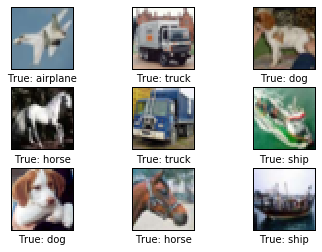

In [13]:
"""
# Get the first images from the test-set.
images = images_test[10:19]

# Get the true classes for those images.
cls_true = cls_test[10:19]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)
"""

###### Create validation from training set.

in "model.fit" function, give the argument "validation_split = 0.20" for 20% convertion of training data into validation data.

###### Or put in your own validation set

In "model.fit" function, give the argument "validation_set = your_set" 

where your_set is your own validation set. this must have the format:

your_set = [(sample1, label1), (sample2, label2), ...]

In [ ]:
top_weights_path = os.path.join(os.path.abspath(model_path), 'top_model_weights.h5')
    callbacks_list = [
        ModelCheckpoint(top_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
        EarlyStopping(monitor='val_acc', patience=5, verbose=0)
    ]

    # Train Simple CNN
    model.fit_generator(train_generator,
                        samples_per_epoch=train_generator.nb_sample,
                        nb_epoch=nb_epoch / 5,
                        validation_data=validation_generator,
                        nb_val_samples=validation_generator.nb_sample,
                        callbacks=callbacks_list)

    # verbose
    print("\nStarting to Fine Tune Model\n")

    # add the best weights from the train top model
    # at this point we have the pre-train weights of the base model and the trained weight of the new/added top model
    # we re-load model weights to ensure the best epoch is selected and not the last one.
    model.load_weights(top_weights_path)

    # based_model_last_block_layer_number points to the layer in your model you want to train.
    # For example if you want to train the last block of a 19 layer VGG16 model this should be 15
    # If you want to train the last Two blocks of an Inception model it should be 172
    # layers before this number will used the pre-trained weights, layers above and including this number
    # will be re-trained based on the new data.
    for layer in model.layers[:based_model_last_block_layer_number]:
        layer.trainable = False
    for layer in model.layers[based_model_last_block_layer_number:]:
        layer.trainable = True

    # compile the model with a SGD/momentum optimizer
    # and a very slow learning rate.
    model.compile(optimizer='nadam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # save weights of best training epoch: monitor either val_loss or val_acc
    final_weights_path = os.path.join(os.path.abspath(model_path), 'model_weights.h5')
    callbacks_list = [
        ModelCheckpoint(final_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
        EarlyStopping(monitor='val_loss', patience=5, verbose=0)
    ]

    # fine-tune the model
    model.fit_generator(train_generator,
                        samples_per_epoch=train_generator.nb_sample,
                        nb_epoch=nb_epoch,
                        validation_data=validation_generator,
                        nb_val_samples=validation_generator.nb_sample,
                        callbacks=callbacks_list)

    # save model
    model_json = model.to_json()
    with open(os.path.join(os.path.abspath(model_path), 'model.json'), 'w') as json_file:
        json_file.write(model_json)


if __name__ == '__main__':
    if not len(sys.argv) == 3:
        print('Arguments must match:\npython code/train.py <data_dir/> <model_dir/>')
        print('Example: python code/train.py data/dogs_cats/ model/dog_cats/')
        sys.exit(2)
    else:
        data_dir = os.path.abspath(sys.argv[1])
        train_dir = os.path.join(os.path.abspath(data_dir), 'train')  # Inside, each class should have it's own folder
        validation_dir = os.path.join(os.path.abspath(data_dir), 'validation')  # each class should have it's own folder
        model_dir = os.path.abspath(sys.argv[2])

        os.makedirs(os.path.join(os.path.abspath(data_dir), 'preview'), exist_ok=True)
        os.makedirs(model_dir, exist_ok=True)

    train(train_dir, validation_dir, model_dir)  # train model

    # release memory

##### Model train function --- will leave this for after we learn how to extract features

In [ ]:
def xception_train(train_data_dir, validation_data_dir, model_path):
    base_model = Xception(input_shape=(img_width, img_height, 3), weights='imagenet', include_top=False)

##### Model test function --- will leave this for after we learn how to extract features

In [ ]:
def xception_test(test_data_dir, model_path):
    return 0

##### Optimizer used

In [ ]:
rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
nadam = keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
sgd = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
'''
# how to pass optimizer with detailed parameters
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)
'''